# Model Inferencing with Pretrained Faster RCNN with Pytorch

### Imports

In [ ]:
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.transforms import functional as F

### Download Pretrained Model & Loading

In [ ]:
def load_model():
    """
    Load a pretrained Faster R-CNN model from torchvision
    """
    # Load pretrained model with weights
    weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
    model = fasterrcnn_resnet50_fpn_v2(weights=weights, box_score_thresh=0.9)
    model.eval()  # Set the model to evaluation mode

    return model, weights.meta["categories"]

### Image Processing

In [ ]:
def preprocess_image(image_path):
    """
    Load and preprocess an image for the model
    """
    # Read image
    image = Image.open(image_path).convert("RGB")

    # Convert to tensor
    image_tensor = F.to_tensor(image)

    return image, image_tensor

### Model Prediction

In [ ]:
def perform_detection(model, image_tensor):
    """
    Run inference with the model on the input image
    """
    with torch.no_grad():
        prediction = model([image_tensor])

    return prediction[0]  # Return the first (and only) prediction

### Class labels, Confidence Scores & Bounding Box Coordinates

### Adding Bounding Box to our results for Visualization

In [ ]:
def visualize_detections(image, prediction, category_names):
    """
    Visualize the detection results with bounding boxes
    """
    # Convert PIL image to numpy array for OpenCV
    image_np = np.array(image)
    image_np = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)

    # Get the prediction components
    boxes = prediction['boxes'].cpu().numpy().astype(np.int32)
    scores = prediction['scores'].cpu().numpy()
    labels = prediction['labels'].cpu().numpy()

    # Create a copy of the image to draw on
    image_with_boxes = image_np.copy()

    # Define color map (for different classes)
    color_map = {}

    # Draw each bounding box
    for box, score, label in zip(boxes, scores, labels):
        # Only show detections with score > threshold (already filtered by model)
        # Get color for this class
        if label not in color_map:
            color_map[label] = (
                np.random.randint(0, 255),
                np.random.randint(0, 255),
                np.random.randint(0, 255)
            )
        color = color_map[label]

        # Draw bounding box
        cv2.rectangle(
            image_with_boxes,
            (box[0], box[1]),
            (box[2], box[3]),
            color,
            2
        )

        # Create label text
        label_text = f"{category_names[label]}: {score:.2f}"

        # Get text size and baseline
        text_size, baseline = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)

        # Draw label background
        cv2.rectangle(
            image_with_boxes,
            (box[0], box[1] - text_size[1] - 5),
            (box[0] + text_size[0], box[1]),
            color,
            -1
        )

        # Draw label text
        cv2.putText(
            image_with_boxes,
            label_text,
            (box[0], box[1] - 5),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            (255, 255, 255),
            1,
            cv2.LINE_AA
        )

    # Convert back to RGB for matplotlib
    image_with_boxes = cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB)

    return image_with_boxes

### Adding all components together for Inferencing with main function

In [ ]:
def main(image_path):
    """
    Main function to run object detection and visualization
    """
    # Load model and categories
    model, categories = load_model()
    print(f"Model loaded with {len(categories)} categories")

    # Load and preprocess image
    image, image_tensor = preprocess_image(image_path)

    # Run detection
    prediction = perform_detection(model, image_tensor)

    # Get detection counts
    num_detections = len(prediction['boxes'])
    print(f"Detected {num_detections} objects")

    # Visualize detections
    result_image = visualize_detections(image, prediction, categories)

    # Display results
    plt.figure(figsize=(12, 8))
    plt.imshow(result_image)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    # Print detection details
    print("\nDetection Details:")
    for i in range(num_detections):
        box = prediction['boxes'][i].cpu().numpy().astype(np.int32)
        score = prediction['scores'][i].cpu().numpy()
        label = prediction['labels'][i].cpu().numpy()
        print(f"Object {i+1}: {categories[label]}, Score: {score:.2f}, Box: {box}")

    return result_image

### Pass your Input Image here for inferencing

Model loaded with 91 categories
Detected 7 objects


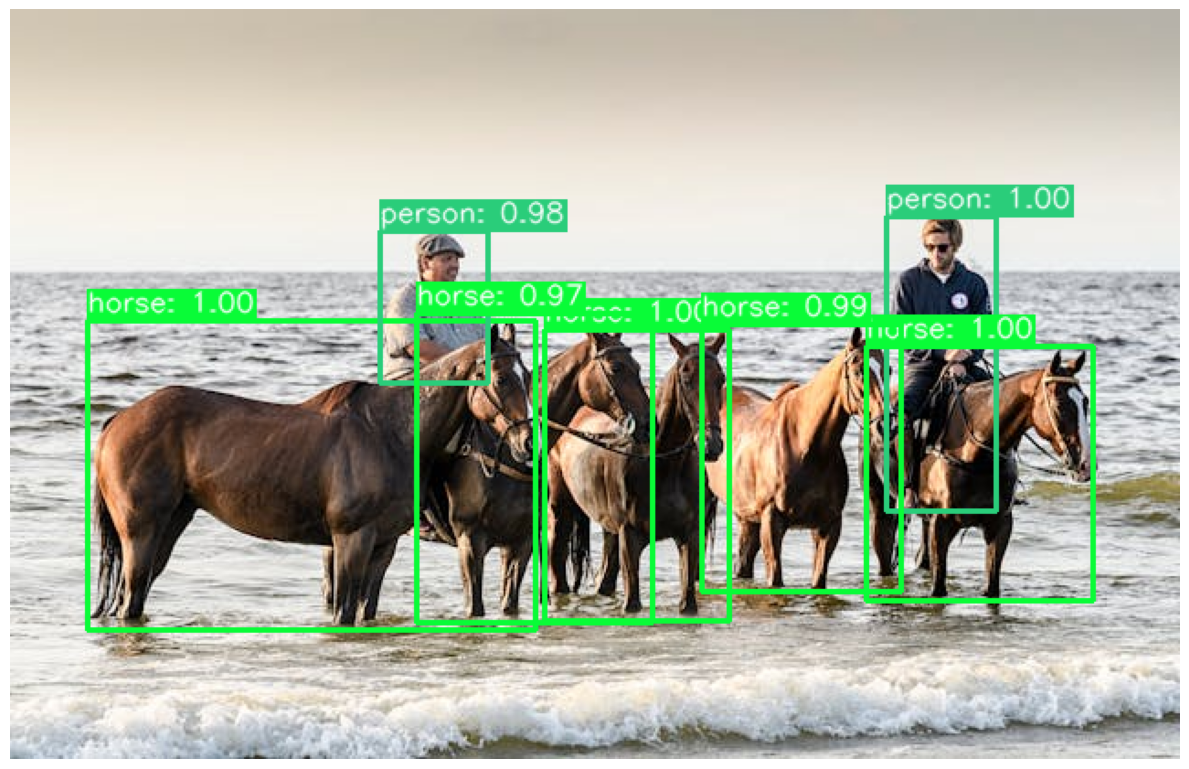


Detection Details:
Object 1: person, Score: 1.00, Box: [479 113 539 274]
Object 2: horse, Score: 1.00, Box: [468 184 592 323]
Object 3: horse, Score: 1.00, Box: [292 175 393 334]
Object 4: horse, Score: 1.00, Box: [ 42 170 287 339]
Object 5: horse, Score: 0.99, Box: [378 172 487 318]
Object 6: person, Score: 0.98, Box: [202 121 261 204]
Object 7: horse, Score: 0.97, Box: [222 166 351 335]


In [ ]:
  image_path = "/content/p_b.jpg"
  result = main(image_path)